<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Windowed Computations

Xarray has built-in support for windowed operations:
1. [rolling](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations) - Sliding windows of fixed length.
2. [coarsen](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays) - block windows of fixed length.


In this notebook, we'll learn to 
1. Compute rolling, or sliding window, means along one or more dimensions.
2. Compute block averages along a dimension.
3. Use `construct` to reshape arrays so that a new dimension provides windowed views to the data.


In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [10]:
ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

## Rolling or moving windows

Rolling window operations 
1. can be applied along any dimension, or along multiple dimensions.
2. returns object of same shape as input
3. pads with NaNs to make (3) possible

Again, all common reduction operations are [available](https://docs.xarray.dev/en/stable/api.html#rolling-objects)

In [11]:
rolling = ds.rolling(time=12, center=True)
rolling

DatasetRolling [time->12(center)]

<div class="alert alert-info">
    Xarrays' computation methods (groupby, groupby_bins, rolling, coarsen, weighted) all return special objects that represent the basic underlying computation pattern. For e.g. `rolling` above is a `DatasetRolling` object that represents 12-point rolling windows of the data in `ds` . It is usually helpful to save and reuse these objects for multiple operations (e.g. a mean and standard deviation calculation).
</div>

In [12]:
ds_rolling = rolling.mean()
ds_rolling

<xarray.Dataset>
Dimensions:    (time: 624, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 nan nan nan nan nan ... nan nan nan nan nan
    sst        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

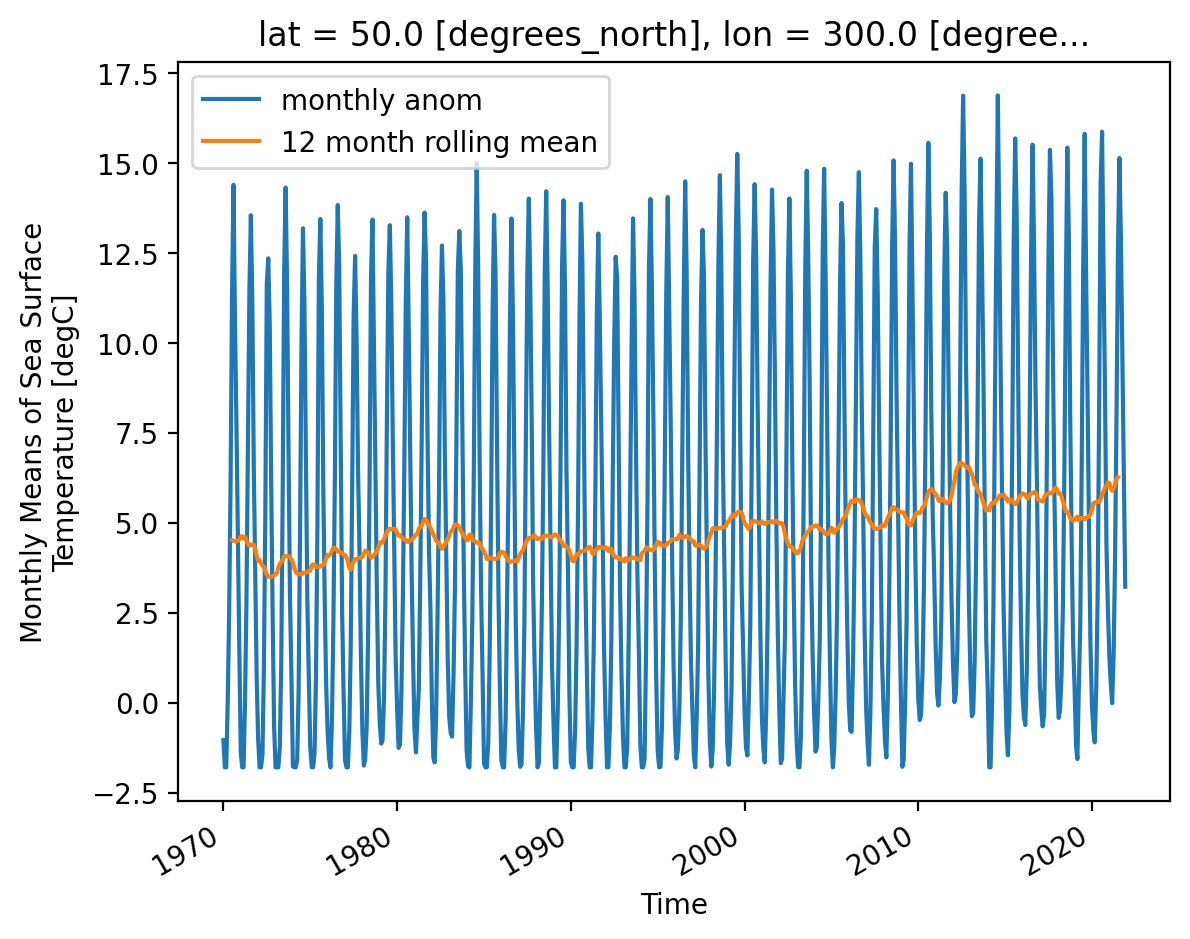

In [13]:
ds.sst.sel(lon=300, lat=50).plot(label="monthly anom")
ds_rolling.sst.sel(lon=300, lat=50).plot(label="12 month rolling mean")
plt.legend()

We can apply rolling mean along multiple dimensions as a 2D smoother in (lat, lon). Here is an example of a 5-point running mean applied along both the `lat` and `lon` dimensions

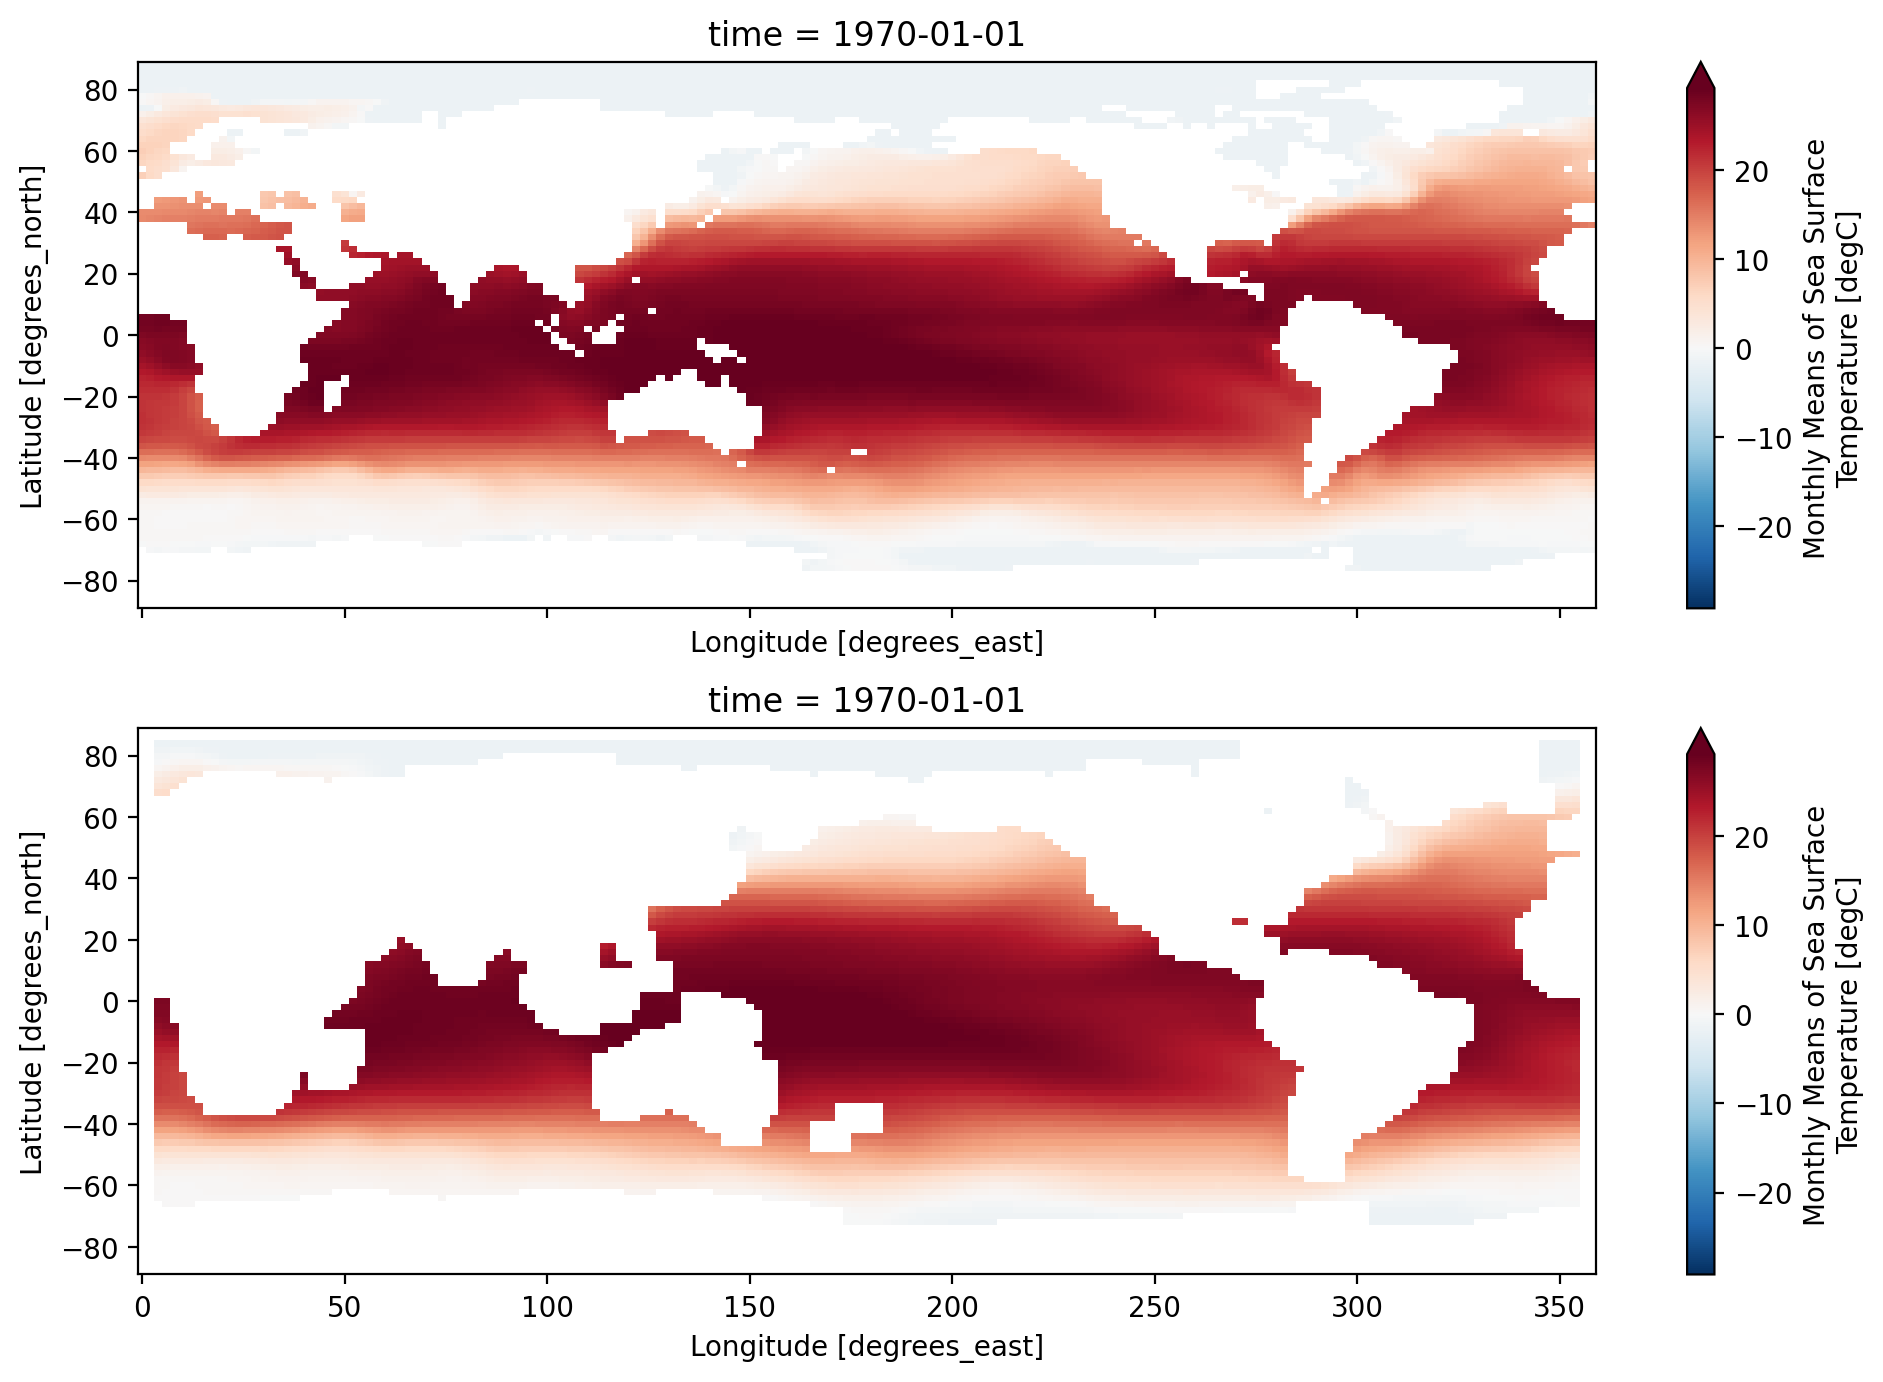

In [14]:
extract = ds.sst.isel(time=0)
smoothed = extract.rolling(lon=5, lat=5, center=True).mean()

f, ax = plt.subplots(2, 1, sharex=True, sharey=True)
extract.plot(ax=ax[0], robust=True)
smoothed.plot(ax=ax[1], robust=True)
f.set_size_inches((10, 7))
plt.tight_layout()

Note the addition of NaNs at the data boundaries and near continental boundaries.

### Custom reductions

While common reductions are implemented by default, sometimes it is useful to apply our own windowed operations. For these uses, Xarray provides the `construct` methods for [DataArray.rolling](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.construct.html) and [Dataset.rolling](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DatasetRolling.construct.html).

For rolling over a dimension `time` with a window size `N`, `construct` adds a new dimension (with user-provided name) of size `N`. 

We illustrate with a simple example array:

In [15]:
simple = xr.DataArray(np.arange(10), dims="time", coords={"time": np.arange(10)})
simple

<xarray.DataArray (time: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9

We call `construct` and provide a name for the new dimension: `window`

In [16]:
# adds a new dimension "window"
simple.rolling(time=5, center=True).construct("window")

<xarray.DataArray (time: 10, window: 5)>
array([[nan, nan,  0.,  1.,  2.],
       [nan,  0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.,  4.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  6.,  7.],
       [ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., nan],
       [ 7.,  8.,  9., nan, nan]])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

### Exercise


Illustrate the difference between `center=True` and `center=False` for rolling by looking at the `construct`-ed array.

In [17]:
display("center=True")
display(simple.rolling(time=5, center=True).construct("window"))

display("center=True")
display(simple.rolling(time=5, center=False).construct("window"))

'center=True'

<xarray.DataArray (time: 10, window: 5)>
array([[nan, nan,  0.,  1.,  2.],
       [nan,  0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.,  4.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  6.,  7.],
       [ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., nan],
       [ 7.,  8.,  9., nan, nan]])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

'center=True'

<xarray.DataArray (time: 10, window: 5)>
array([[nan, nan, nan, nan,  0.],
       [nan, nan, nan,  0.,  1.],
       [nan, nan,  0.,  1.,  2.],
       [nan,  0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.,  4.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  6.,  7.],
       [ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.]])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

## Coarsening

`coarsen` does something similar to `rolling`, but allows us to work with discrete *non-overlapping* blocks of data.

You will need to specify `boundary` if the length of the dimension is not a multiple of the window size ("block size"). You can choose to
1. `trim` the excess values
2. `pad` with NaNs

Again, all standard reductions are [implemented](https://docs.xarray.dev/en/stable/api.html#coarsen-objects).

In [18]:
coarse = ds.coarsen(lon=5, lat=5)
coarse

DatasetCoarsen [windows->{'lon': 5, 'lat': 5},side->left]

<div class="alert alert-info">
    Xarrays' computation methods (groupby, groupby_bins, rolling, coarsen, weighted) all return special objects that represent the basic underlying computation pattern. For e.g. `coarse` above is a `DatasetCoarsen` object that represents 5-point windows along lat, lon of the data in `ds`. It is usually helpful to save and reuse these objects for multiple operations (e.g. a mean and standard deviation calculation).
</div>

In [ ]:
# we expect an error here because lat has size 89, which is not divisible by block size 5
coarse.mean()

In [ ]:
coarse = ds.coarsen(lat=5, lon=5, boundary="trim").mean()
coarse

In [ ]:
coarse.sst.isel(time=0).plot();

### Custom reductions

Like `rolling`, `coarsen` also provides a `construct` method for custom block operations. 

**Tip** `coarsen.construct` is a handy way to reshape Xarray objects.

Consider a "monthly" 1D timeseries. This simple example has one value per month for 2 years

In [ ]:
months = xr.DataArray(
    np.tile(np.arange(1, 13), reps=2),
    dims="time",
    coords={"time": np.arange(1, 25)},
)
months

Now we reshape to get one new dimension `year` of size 12.

In [ ]:
# break "time" into two new dimensions: "year", "month"
months.coarsen(time=12).construct(time=("year", "month"))

### Exercise

Imagine the array `months` was one element shorter. Use `boundary="pad"` and the `side` kwarg to reshape `months.isel(time=slice(1, None))` to a 2D DataArray with the following values:

```
array([[nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]])
```

In [ ]:
months.isel(time=slice(1, None)).coarsen({"time": 12}, boundary="pad", side="right").construct(
    time=("year", "month")
)

Note that `coarsen` pads with NaNs. For more control over paddnig, use
[DataArray.pad](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.pad.html) explicitly.

## Going further

1. See the documentation on [rolling](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations) and [coarsen](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays).
2. Follow the tutorial on [high-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html#)